In [67]:
#Importación de librerías necesarias
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error

le = LabelEncoder()

In [2]:
# Definición del archivo a leer
FILE_PATH = '../project/airbnb-listings-extract.csv'
ARRAY_OBJECTS_COLUMNS_TO_DROP = ['Calendar Updated', 'Calendar last Scraped', 'First Review', 'Last Review', 'Listing Url',
                         'Last Scraped', 'Name', 'Summary', 'Space', 'Description', 'Neighborhood Overview', 'Notes',
                         'Transit', 'Access', 'Interaction', 'House Rules', 'Thumbnail Url', 'Medium Url', 'Picture Url',
                         'XL Picture Url', 'Host URL', 'Host Name', 'Host Since', 'Host Location', 'Host About', 
                         'Host Thumbnail Url', 'Amenities', 'License', 'Host Picture Url']
ARRAY_NUMERIC_COLUMNS_TO_DROP = ['Weekly Price', 'Monthly Price', 'ID', 'Scrape ID', 'Host ID', 'Geolocation']
COLUMNS_TO_TRANSFORM_NA = ['Review Scores Rating', 'Review Scores Accuracy', 'Review Scores Cleanliness',
                          'Review Scores Checkin', 'Review Scores Communication', 'Review Scores Location',
                          'Review Scores Value', 'Reviews per Month', 'Security Deposit', 'Cleaning Fee',
                          'Host Response Rate', 'Host Listings Count', 'Host Total Listings Count']
COLUMNS_TO_TRANSFORM = ['Availability 90', 'Availability 30', 'Availability 60', 'Availability 365']

In [3]:
# Definición de variables a usar
train_columns_null = []
test_columns_null = []

In [42]:
# Definición de funciones a usar tanto en TRAIN como en TEST

# Eliminar los registros que no sean de Madrid de los datos pasados
def drop_data_not_equals_madrid(df):
    df = df[df.City == 'Madrid']
    return df

def drop_price_is_null(df):
    df = df[df['Price'].isnull() == False]
    return df

# Eliminar las columnas indicadas en el array
def drop_columns(df, array_columns):
    df = df.drop(array_columns, axis=1)
    return df
    
# Eliminar las variables que indican territorio por estar filtrado con los registros
def drop_territory_columns(df):
    df = drop_columns(df, ['State', 'Country Code', 'Smart Location', 'Country', 'City' ])
    return df
    
# Obtener las columnas que no tienen valores en sus registros
def get_null_columns(df, array_columns_null):
    for col in df.columns:
        if len(df[col][df[col].isnull()]) == len(df):
            array_columns_null.append(col)

def move_price_to_first_colum(df):
    cols = df.columns.tolist()
    cols = cols[-(len(cols) - cols.index('Price')):] + cols[0:cols.index('Price')]
    return df[cols]

def standar_col(col):
    mean = np.mean(col)
    std = np.std(col)
    if (mean > 0) & (std > 0):
        col.apply(lambda x: (x - mean) / std)
    return col

def transform_with_label_encoder(df, columnName):
    df[columnName] = le.fit_transform(df[columnName])
    df[columnName] = standar_col(df[columnName])
    return df

def change_column_in_category(df):
    types = df.dtypes
    columnsObject = (types[types == 'object']).keys()
    for column in columnsObject:
        if len(df[column][df[column].isnull()]) > 0:
            df[column].fillna("UNKNOW", inplace=True)        
        df = transform_with_label_encoder(df, column)
    return df

def transform_with_hundreds(val):
    if val == 1000:
        return '1000'
    elif 900.0 <= val < 1000.0:
        return '900-999.99'
    elif 800.0 <= val < 900.0:
        return '800-899.99'
    elif 700.0 <= val < 800.0:
        return '700-799.99'
    elif 600.0 <= val < 700.0:
        return '600-699.99'
    elif 500.0 <= val < 600.0:
        return '500-599.99'
    elif 400.0 <= val < 500.0:
        return '400-499.99'
    elif 300.0 <= val < 400.0:
        return '300-399.99'
    elif 200.0 <= val < 300.0:
        return '200-299.99'
    elif 100.0 <= val < 200.0:
        return '100-199.99'
    elif val < 100.0:
        return '0-99.99'

def transform_with_tens(val):
    if val == 100:
        return '100'
    elif 90.0 <= val < 100.0:
        return '90-99'
    elif 80.0 <= val < 90.0:
        return '80-89'
    elif 70.0 <= val < 80.0:
        return '70-79'
    elif 60.0 <= val < 70.0:
        return '60-69'
    elif 50.0 <= val < 60.0:
        return '50-59'
    elif 40.0 <= val < 50.0:
        return '40-49'
    elif 30.0 <= val < 40.0:
        return '30-39'
    elif 20.0 <= val < 30.0:
        return '20-29'
    elif 10.0 <= val < 20.0:
        return '10-19'
    elif val < 10.0:
        return '0-9'
    
def transform_with_units(val):
    if type(val) == str:
        return val
    elif val == 10:
        return '10'
    elif 9.0 <= val < 10.0:
        return '9-9.99'
    elif 8.0 <= val < 9.0:
        return '8-8.99'
    elif 7.0 <= val < 8.0:
        return '7-7.99'
    elif 6.0 <= val < 7.0:
        return '6-6.99'
    elif 5.0 <= val < 6.0:
        return '5-5.99'
    elif 4.0 <= val < 5.0:
        return '4-4.99'
    elif 3.0 <= val < 4.0:
        return '3-3.99'
    elif 2.0 <= val < 3.0:
        return '2-2.99'
    elif 1.0 <= val < 2.0:
        return '1-1.99'
    elif val < 1.0:
        return '0-0.99'
    
def reviews_transform(val):
    if type(val) == str:
        return val
    elif val < 10:
        return transform_with_units(val)
    elif 10.00 <= val < 100.0:
        return transform_with_tens(val)
    else:
        return transform_with_hundreds(val)
    
def transform_columns_na(df):
    for counter in range(len(COLUMNS_TO_TRANSFORM_NA)):
        columnName = COLUMNS_TO_TRANSFORM_NA[counter]
        if df[columnName].isnull().sum() > 0:
            df[ columnName ].fillna("No Data", inplace=True)
            df[columnName] = df[columnName].apply(reviews_transform)
    for column in COLUMNS_TO_TRANSFORM:
        if df[columnName].isnull().sum() > 0:
            df[ columnName ].fillna("No Data", inplace=True)
        df[columnName] = df[columnName].apply(reviews_transform)
    return df

def fill_null_data(df, column, value):
    df[column] = df[ column ].fillna(value, inplace=False)
    return df

def process_data_no_train(df):
    # Eliminar registros que no sean de Madrid
    df = drop_data_not_equals_madrid(df)
    if (len(df) > 0):
        # Eliminar las variables de territorio
        df = drop_territory_columns(df)
        # Eliminar las columnas que no tenían datos en test
        df = drop_columns(df, train_columns_null)
        # Mover Price a la primera columna
        df = move_price_to_first_colum(df)
        # Eliminar columnas que no merece la pena categorizar
        df = drop_columns(df, ARRAY_OBJECTS_COLUMNS_TO_DROP)
        # Cambiar las variables object a categoricas
        df = change_column_in_category(df)
        # Eliminar variables númericas que no se van a usar
        df = drop_columns(df, ARRAY_NUMERIC_COLUMNS_TO_DROP)
        # Solucionar problemas Null/NAN
        df = transform_columns_na(df)
        df = change_column_in_category(df)
        df = drop_price_is_null(df)
        df = fill_null_data(df, 'Bathrooms', 1)
        df = fill_null_data(df, 'Bedrooms', 1)
        df = fill_null_data(df, 'Beds', 2)
        df = drop_columns(df, ['Square Feet'])
    return df

In [5]:
#Lectura de archivo de datos y verifico que lo he cargado correctamente.
data = pd.read_csv( FILE_PATH,sep=';', decimal='.')
# Vamos a saber cuantos registros y variables tenemos
print(data.shape)

(14780, 89)


In [6]:
# Separamos los datos en TRAIN y TEST
train, test = train_test_split(data, test_size=0.2, shuffle=True, random_state=0)
print(f'Registros del dataset de training: {train.shape[0]}')
print(f'Registros del dataset de test: {test.shape[0]}')

Registros del dataset de training: 11824
Registros del dataset de test: 2956


In [7]:
# Guardamos los datos de Entrenamiento y Test así nos aseguramos de tenerlos separados y guardados.
train.to_csv('./train.csv', sep=';', decimal='.', index=False)
test.to_csv('./test.csv', sep=';', decimal='.', index=False)

In [8]:
# Ahora vamos a cargar los datos de TRAIN para empezar a trabajar sobre ellos y ver qué habría que hacer.
dataTrain = pd.read_csv('./train.csv', sep=';', decimal='.')

In [9]:
# Verificamos que se han cargado todos los registros
print("Los datos leídos deberían ser 11.824 según la separación anterior, datos realmente leídos: ", dataTrain.shape[0])

Los datos leídos deberían ser 11.824 según la separación anterior, datos realmente leídos:  11824


In [10]:
# muestro las columnas para hacerme una idea de qué campos tengo.
columnNames = data.columns
print(columnNames)

Index(['ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary',
       'Space', 'Description', 'Experiences Offered', 'Neighborhood Overview',
       'Notes', 'Transit', 'Access', 'Interaction', 'House Rules',
       'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url',
       'Host ID', 'Host URL', 'Host Name', 'Host Since', 'Host Location',
       'Host About', 'Host Response Time', 'Host Response Rate',
       'Host Acceptance Rate', 'Host Thumbnail Url', 'Host Picture Url',
       'Host Neighbourhood', 'Host Listings Count',
       'Host Total Listings Count', 'Host Verifications', 'Street',
       'Neighbourhood', 'Neighbourhood Cleansed',
       'Neighbourhood Group Cleansed', 'City', 'State', 'Zipcode', 'Market',
       'Smart Location', 'Country Code', 'Country', 'Latitude', 'Longitude',
       'Property Type', 'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Bed Type', 'Amenities', 'Square Feet', 'Price', 'Weekly Price',
       'Month

In [11]:
# Para empezar a limpiar los datos tengo que ver cuantos datos tengo según la ciudad. 
dataTrain['City'].value_counts()

Madrid                                 10567
Barcelona                                235
London                                   104
Paris                                     85
Palma                                     44
                                       ...  
Lewisham                                   1
Santa Ponsa                                1
Madrid, Comunidad de Madrid, ESPANA        1
Port de Pollença                           1
Tsim Sha Tsui                              1
Name: City, Length: 222, dtype: int64

In [12]:
# Veo que si escojo solo los datos de Madrid tengo suficientes registros como para asegurar el entrenamiento
# Me quedo con todos los registros de Madrid
dataTrain = drop_data_not_equals_madrid(dataTrain)
print("Según los datos vistos, tengo 10.567 datos de Madrid, los registros tras la eliminación: ", dataTrain.shape[0])
# Veo que me concuerda el número de Registros con los registros que me había indicado antes que tenía Madrid.

Según los datos vistos, tengo 10.567 datos de Madrid, los registros tras la eliminación:  10567


In [13]:
# Comprobando los datos que tienen las columnas que nos indican que el registro es de Madrid, porque si todo es correcto
# Podemos eliminar esas variables porque no nos afectarán al modelo.
# 'State' 'Country Code' 'Smart Location' 'Country' 'City'
dataTrain = drop_territory_columns(dataTrain)
print(dataTrain.shape)

(10567, 84)


In [14]:
# Voy a comprobar si hay columnas en entrenamiento que no tengan ningún valor en los datos, en caso que sí, 
# las elimino completamente
get_null_columns(dataTrain, train_columns_null)
if len(train_columns_null) > 0:
    print(train_columns_null)
    dataTrain = drop_columns(dataTrain, train_columns_null)
print(dataTrain.shape)

['Host Acceptance Rate', 'Has Availability', 'Jurisdiction Names']
(10567, 81)


In [15]:
# Mover a la primera columna la variable precio. Para asegurarnos de que sabemos donde localizarla
dataTrain = move_price_to_first_colum(dataTrain)
print("Ahora el precio está en la primera columna: ", dataTrain.columns[0])

Ahora el precio está en la primera columna:  Price


In [16]:
# Eliminar del dataFrame las columnas object que no merece la pena categorizar
dataTrain = drop_columns(dataTrain, ARRAY_OBJECTS_COLUMNS_TO_DROP)

In [17]:
# Cambiar las variables object a variables categoricas
dataTrain = change_column_in_category(dataTrain)

In [18]:
# Eliminar columnas númericas que no aportan para el cálculo
dataTrain = drop_columns(dataTrain, ARRAY_NUMERIC_COLUMNS_TO_DROP)

In [19]:
columnsWithNAN = dataTrain.isnull().sum()
print("Las variables que tienen valores Null o NAN en sus registros")
print(columnsWithNAN[ columnsWithNAN > 0])
dataTrain = transform_columns_na(dataTrain)
print("")
print("Las variables que tienen valores Null o NAN en sus registros tras la transformación de 'reviews'")
columnsWithNAN = dataTrain.isnull().sum()
print(columnsWithNAN[ columnsWithNAN > 0])

Las variables que tienen valores Null o NAN en sus registros
Price                              8
Security Deposit                6018
Cleaning Fee                    4285
Review Scores Rating            2286
Review Scores Accuracy          2302
Review Scores Cleanliness       2297
Review Scores Checkin           2308
Review Scores Communication     2298
Review Scores Location          2311
Review Scores Value             2310
Reviews per Month               2179
Host Response Rate              1313
Host Listings Count                3
Host Total Listings Count          3
Bathrooms                         40
Bedrooms                          18
Beds                              37
Square Feet                    10154
dtype: int64

Las variables que tienen valores Null o NAN en sus registros tras la transformación de 'reviews'
Price              8
Bathrooms         40
Bedrooms          18
Beds              37
Square Feet    10154
dtype: int64


In [20]:
print("En el paso anterior hemos transformado variables númericas a 'String', por lo que hay que hacerlas categóricas")
dataTrain = change_column_in_category(dataTrain)

En el paso anterior hemos transformado variables númericas a 'String', por lo que hay que hacerlas categóricas


In [21]:
print("Eliminamos todas aquellas filas con precio a 0, pues no nos valdrá para el entrenamiento")
dataTrain = drop_price_is_null(dataTrain)
print("")
print("Las variables que tienen valores Null o NAN en sus registros tras la transformación de 'reviews'")
columnsWithNAN = dataTrain.isnull().sum()
print(columnsWithNAN[ columnsWithNAN > 0])

Eliminamos todas aquellas filas con precio a 0, pues no nos valdrá para el entrenamiento

Las variables que tienen valores Null o NAN en sus registros tras la transformación de 'reviews'
Bathrooms         39
Bedrooms          18
Beds              36
Square Feet    10146
dtype: int64


In [22]:
print("Para [Bathrooms-Bedrooms]: ")
print(dataTrain["Bathrooms"].describe())
print(dataTrain["Bedrooms"].describe())
print("La media se acerca a 1 y la desviación típica se acerca más al 1 que al 0. Por lo tanto decido rellenar a 1 los nulos.")
dataTrain = fill_null_data(dataTrain, 'Bathrooms', 1)
dataTrain = fill_null_data(dataTrain, 'Bedrooms', 1)
print("Para Beds: ")
print(dataTrain["Beds"].describe())
print("La media se acerca a 2 y la desviación típica se acerca más al 2 que al 1. Por lo tanto decido rellenar a 2 los nulos.")
dataTrain = fill_null_data(dataTrain, 'Beds', 2)

Para [Bathrooms-Bedrooms]: 
count    10520.000000
mean         1.256179
std          0.606286
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          8.000000
Name: Bathrooms, dtype: float64
count    10541.000000
mean         1.294469
std          0.832908
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         10.000000
Name: Bedrooms, dtype: float64
La media se acerca a 1 y la desviación típica se acerca más al 1 que al 0. Por lo tanto decido rellenar a 1 los nulos.
Para Beds: 
count    10523.000000
mean         1.992113
std          1.528676
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         16.000000
Name: Beds, dtype: float64
La media se acerca a 2 y la desviación típica se acerca más al 2 que al 1. Por lo tanto decido rellenar a 2 los nulos.


Para la variable 'Square Feet', tiene  413  registros
Para nuestro trabajo, sería una variable que vendría bien, pero que nos ocasionaría más problemas que beneficios.
O se rellena con la meda y no lo veo positivo por tener valores tan dispares
count     413.000000
mean      375.266344
std       556.981908
min         0.000000
25%         0.000000
50%        97.000000
75%       646.000000
max      5167.000000
Name: Square Feet, dtype: float64


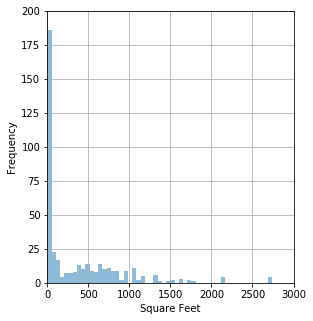

Por lo que opto por eliminar la variable antes de empezar el modelo.


In [23]:
print("Para la variable 'Square Feet', tiene ", len(dataTrain) - dataTrain["Square Feet"].isnull().sum(), " registros")
print("Para nuestro trabajo, sería una variable que vendría bien, pero que nos ocasionaría más problemas que beneficios.")
print("O se rellena con la meda y no lo veo positivo por tener valores tan dispares")
print(dataTrain["Square Feet"].describe())
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
dataTrain['Square Feet'].plot.hist(alpha=0.5, bins=100, grid = True)
plt.axis([0, 3000, 0, 200])
plt.xlabel('Square Feet')
plt.show()
print("Por lo que opto por eliminar la variable antes de empezar el modelo.")
dataTrain = drop_columns(dataTrain, ['Square Feet'])

In [24]:
print("Las variables que tienen valores Null o NAN en sus registros tras la transformación de 'reviews'")
columnsWithNAN = dataTrain.isnull().sum()
print(columnsWithNAN[ columnsWithNAN > 0])

Las variables que tienen valores Null o NAN en sus registros tras la transformación de 'reviews'
Series([], dtype: int64)


In [25]:
dataTrain.dtypes

Price                             float64
Security Deposit                    int32
Cleaning Fee                        int32
Guests Included                     int64
Extra People                        int64
Minimum Nights                      int64
Maximum Nights                      int64
Availability 30                     int64
Availability 60                     int64
Availability 90                     int64
Availability 365                    int64
Number of Reviews                   int64
Review Scores Rating                int32
Review Scores Accuracy              int32
Review Scores Cleanliness           int32
Review Scores Checkin               int32
Review Scores Communication         int32
Review Scores Location              int32
Review Scores Value                 int32
Cancellation Policy                 int32
Calculated host listings count    float64
Reviews per Month                   int32
Features                            int32
Experiences Offered               

In [26]:
# Separamos los datos de TRAIN para empezar a elegir propiedades y entrenar Modelo
cols = dataTrain.columns.tolist()
y_train = dataTrain[cols[0:1]]
X_train = dataTrain[cols[1:]]

In [27]:
# Uso GridSearchCV y RandomForestClassifier para intentar elegir las mejores Propiedades
maxDepth = range(1,15)
tuned_parameters = {'max_depth': maxDepth}

# Creo un modelo de RandomForestClassifier para aplicar al GridSearchCV
featuresModel = RandomForestRegressor(random_state=0, n_estimators=200, max_features='sqrt')

#Creo el GridSearchCV con el modelo y el parametro a analizar con su rango y lo ejecuto con X_train e y_train
grid = GridSearchCV(featuresModel, param_grid=tuned_parameters,cv=10) 
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='sqrt',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=200, n_jobs=None,
                                             oob_score=False, random_state=0,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

best mean cross-validation score: 0.654
best parameters: {'max_depth': 14}


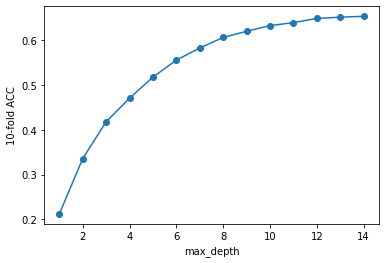

In [28]:
# Una vez tengo los resultados vemos los resultados

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

In [29]:
# Tras ver la gráfica elijo el 9 como el mejor parametro para ver los puntos con X_train y_train
maxDepthOptimo = 9

featuresModel = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt').fit(X_train,y_train)

print("Entrenamiento con 9 como número óptimo: ",featuresModel.score(X_train,y_train))

Entrenamiento con 9 como número óptimo:  0.7741207051194541


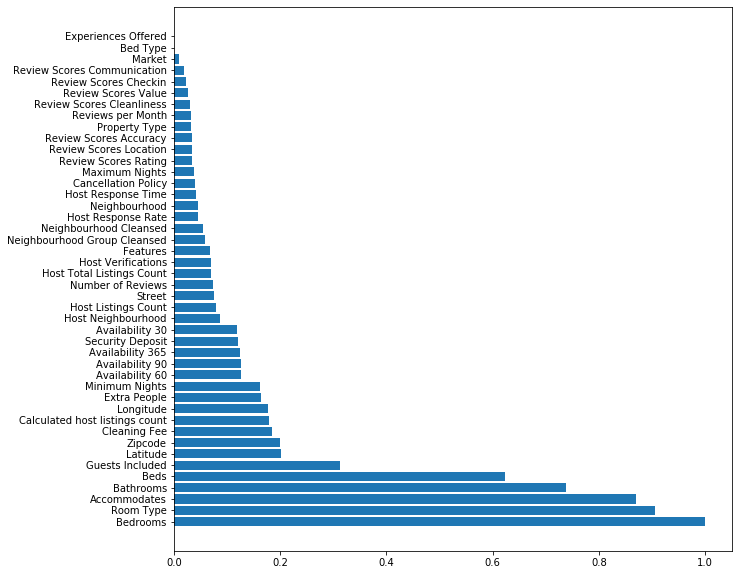

In [30]:
# Y vemos la importancia de las variables para quedarnos con las más favorables
features = X_train.columns

importances = featuresModel.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),features[indices])
plt.show()

In [31]:
N,Nfeatures = X_train.shape

rf = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt')
kf  = KFold(n_splits=10, shuffle = True, random_state=1)
cv_error = []
cv_std = []
cv_name = []

for nfeatures in range(Nfeatures,0,-1):
        
    error_i = []
    
    for idxTrain, idxVal in kf.split(X_train):
      
        Xt = X_train.iloc[idxTrain, :]
        yt = y_train.iloc[idxTrain]
        Xv = X_train.iloc[idxVal, : ]
        yv = y_train.iloc[idxVal]
        
        rf.fit(Xt,yt)
        
        ranking = rf.feature_importances_
        indices = np.argsort(ranking)[::-1]
        
        selected = indices[0:(Nfeatures-nfeatures+1)]
        
        Xs = Xt[Xt.columns[selected]]       
        
        rf.fit(Xs,yt)
        
        error = (1.0-rf.score(Xv[Xv.columns[selected]],yv))     
        error_i.append(error) 
    
    cv_error.append(np.mean(error_i))
    cv_std.append(np.std(error_i))    
    
    print('# features ' + str(len(selected)) + ' error ' + str(np.mean(error_i)) + ' +/- ' + str(np.std(error_i)))    


# features 1 error 0.6962963544738673 +/- 0.0729664275091719
# features 2 error 0.6065545070152822 +/- 0.06668872748349221
# features 3 error 0.5561466102084457 +/- 0.06785448305075265
# features 4 error 0.46939827080908697 +/- 0.0752756921962555
# features 5 error 0.4739490905628654 +/- 0.07400243018382732
# features 6 error 0.4666768332556746 +/- 0.06547855027445076
# features 7 error 0.44777858657936803 +/- 0.06388697252817487
# features 8 error 0.43937552212360675 +/- 0.060428996791915594
# features 9 error 0.4331335608149975 +/- 0.06113781086893663
# features 10 error 0.40587505335745033 +/- 0.05875369787252842
# features 11 error 0.4013120042503665 +/- 0.06020044080097693
# features 12 error 0.39200326927989926 +/- 0.054422069988085485
# features 13 error 0.38527468131765863 +/- 0.05457500370939986
# features 14 error 0.382773877131923 +/- 0.05270667593577413
# features 15 error 0.37815540583511703 +/- 0.044273977682452816
# features 16 error 0.37738227449968537 +/- 0.04603665289

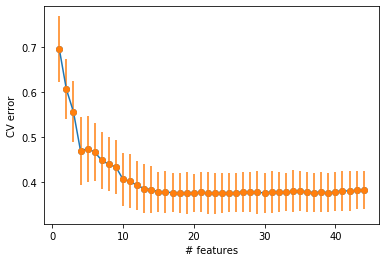

In [34]:
plt.plot(range(1,Nfeatures+1,1),cv_error,'-o')
plt.errorbar(range(1,Nfeatures+1,1), cv_error, yerr=cv_std, fmt='o')
plt.xlabel('# features')
plt.ylabel('CV error')
lt.show()

In [120]:
print("Mi primera Selección: ")
print("Las variables elegidas para entrenar el modelo:  Index(['Bedrooms', 'Accommodates', 'Room Type', 'Bathrooms', 'Beds',",
       "'Guests Included', 'Zipcode', 'Latitude', 'Cleaning Fee',",
       "'Extra People', 'Calculated host listings count', 'Availability 60',",
       "'Minimum Nights', 'Longitude', 'Availability 30', 'Security Deposit',",
       "'Availability 365', 'Availability 90']")
print("Se escoge 18 variables, aunque saldría mejor con 23, no hay tanta diferencia y se complicaría mucho el modelo")
selected_features = indices[0:18]
print("Las variables elegidas para entrenar el modelo: ",X_train.columns[selected_features])

Mi primera Selección: 
Las variables elegidas para entrenar el modelo:  Index(['Bedrooms', 'Accommodates', 'Room Type', 'Bathrooms', 'Beds', 'Guests Included', 'Zipcode', 'Latitude', 'Cleaning Fee', 'Extra People', 'Calculated host listings count', 'Availability 60', 'Minimum Nights', 'Longitude', 'Availability 30', 'Security Deposit', 'Availability 365', 'Availability 90']
Se escoge 18 variables, aunque saldría mejor con 23, no hay tanta diferencia y se complicaría mucho el modelo
Las variables elegidas para entrenar el modelo:  Index(['Bedrooms', 'Accommodates', 'Room Type', 'Bathrooms', 'Beds',
       'Guests Included', 'Zipcode', 'Latitude', 'Cleaning Fee',
       'Extra People', 'Calculated host listings count', 'Availability 60',
       'Minimum Nights', 'Longitude', 'Availability 30', 'Security Deposit',
       'Availability 365', 'Availability 90'],
      dtype='object')


In [60]:
print("Es hora de cargar los datos de test y ver qué tal es de eficiente el modelo tras entrenarlo.")
testData = pd.read_csv('./test.csv', sep=';', decimal='.')
print("Tal y como hemos hecho con los datos de TRAIN, tenemos que hacer con los de TEST")
testData = process_data_no_train(testData)

Es hora de cargar los datos de test y ver qué tal es de eficiente el modelo tras entrenarlo.
Tal y como hemos hecho con los datos de TRAIN, tenemos que hacer con los de TEST


In [61]:
# Volvemos a coger los datos de train y los de test, para entrenar al modelo y probarlo con los de test
y_train = dataTrain[cols[0:1]]
X_train = dataTrain[cols[1:]]

y_test = testData[cols[0:1]]
X_test = testData[cols[1:]]

In [108]:
# Entrenamos al modelo y vemos los resultados
priceModel = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt')
priceModel.fit(X_train.iloc[:, selected_features],y_train)

print("Train: ",priceModel.score(X_train.iloc[:, selected_features],y_train))
print("Test: ",priceModel.score(X_test.iloc[:, selected_features],y_test))

yTrainModel = priceModel.predict(X_train.iloc[:, selected_features])
yTestModel = priceModel.predict(X_test.iloc[:, selected_features])

mseTrain = mean_squared_error(y_train, yTrainModel)
mseTest = mean_squared_error(y_test, yTestModel)

print('MSE Modelo RandomForestRegressor (train): %0.3g' % mseTrain)
print('MSE Modelo RandomForestRegressor (test) : %0.3g' % mseTest)

print('RMSE Modelo RandomForestRegressor (train): %0.3g' % np.sqrt(mseTrain))
print('RMSE Modelo RandomForestRegressor (test) : %0.3g' % np.sqrt(mseTest))


Train:  0.7747069516033211
Test:  0.6333661310539305
MSE Modelo RandomForestRegressor (train): 711
MSE Modelo RandomForestRegressor (test) : 1.12e+03
RMSE Modelo RandomForestRegressor (train): 26.7
RMSE Modelo RandomForestRegressor (test) : 33.5


In [107]:
r = LinearRegression()
alphas = [1000, 100, 50, 20, 10, 1, 0.1, 0.01]
l1_ratios = [0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9]
ridge = RidgeCV(alphas=alphas)
lasso = LassoCV(alphas=alphas, max_iter=10000)
elastic = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios)

for model, name in zip([lr, ridge, lasso, elastic], ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet']):
    model.fit(X_train.iloc[:, selected_features], y_train)
    print("----")
    print(name,' Train Score ', model.score(X_train.iloc[:, selected_features],y_train))
    print(name, ' Test Score ', model.score(X_test.iloc[:, selected_features],y_test))
        
    y_ModelPredictTrain = model.predict(X_train.iloc[:, selected_features])    
    mseTrain = mean_squared_error(y_train, y_ModelPredictTrain)
    mrse_train = np.sqrt(mseTrain)
    
    y_ModelPredictTest = model.predict(X_test.iloc[:, selected_features])
    mseTest = mean_squared_error(y_test, y_ModelPredictTest)
    mrse_test = np.sqrt(mseTest)
    
    best_alpha = ''
    if name != 'LinearRegression':
        best_alpha = ' best alpha: ' + str(model.alpha_)
    best_l1 = ''
    if name == 'ElasticNet':
        best_l1 = ' best l1: '+ str(model.l1_ratio_)
    print(name + ' mse_train: ' + str(mseTrain) + ', mse_test: ' + str(mseTest) + best_alpha + best_l1)
    print(name + ' mrse_train: ' + str(mrse_train) + ', mrse_test: ' + str(mrse_test) + best_alpha + best_l1)
    

----
LinearRegression  Train Score  0.4766626533933088
LinearRegression  Test Score  0.495386877504237
LinearRegression mse_train: 1650.6657163615525, mse_test: 1547.0263489083122
LinearRegression mrse_train: 40.62838559876029, mrse_test: 39.33225583294597
----
Ridge  Train Score  0.47666138771286326
Ridge  Test Score  0.4954352796766537
Ridge mse_train: 1650.6697084621221, mse_test: 1546.8779591167372 best alpha: 0.1
Ridge mrse_train: 40.628434728181716, mrse_test: 39.330369425124104 best alpha: 0.1
----
Lasso  Train Score  0.47657858014663446
Lasso  Test Score  0.49566229056317684
Lasso mse_train: 1650.9308929763088, mse_test: 1546.1819965916181 best alpha: 0.01
Lasso mrse_train: 40.631648907917935, mrse_test: 39.321520781775696 best alpha: 0.01
----
ElasticNet  Train Score  0.4754488729907409
ElasticNet  Test Score  0.4952293919536449
ElasticNet mse_train: 1654.4941182722923, mse_test: 1547.5091629404426 best alpha: 0.01 best l1: 0.9
ElasticNet mrse_train: 40.67547317822243, mrse_te

In [121]:
print("Elimino las siguientes caracteristicas para simplificar el modelo: ")
print("Zipcode, Latitude, Longitude: si el barrio no se ha considerado, la localización no debe influir mucho.")
print("Calculated host listings count: recuentos calculados de listados del propietario no debe influir.")
print("Availability 60, 30, 90, 365: la disponibilidad no debe influir.")
selected_features = np.delete(selected_features, (6, 7, 10, 11, 13, 14, 16, 17) )

[41 39 38 40 42  2 33 35  1  3 19  7  4 36  6  0  9  8]
41   Bedrooms
39   Accommodates
38   Room Type
40   Bathrooms
42   Beds
2   Guests Included
33   Zipcode
35   Latitude
1   Cleaning Fee
3   Extra People
19   Calculated host listings count
7   Availability 60
4   Minimum Nights
36   Longitude
6   Availability 30
0   Security Deposit
9   Availability 365
8   Availability 90
[41 39 38 40 42  2  1  3  4  0]
[41 39 38 40 42  2 33 35  1  3 19  7  4 36  6  0  9  8]


In [122]:
# Volvemos a coger los datos de train y los de test, para entrenar al modelo y probarlo con los de test
y_train = dataTrain[cols[0:1]]
X_train = dataTrain[cols[1:]]

y_test = testData[cols[0:1]]
X_test = testData[cols[1:]]

# Entrenamos al modelo y vemos los resultados
priceModel = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt')
priceModel.fit(X_train.iloc[:, selected_features],y_train)

print("Train: ",priceModel.score(X_train.iloc[:, selected_features],y_train))
print("Test: ",priceModel.score(X_test.iloc[:, selected_features],y_test))

yTrainModel = priceModel.predict(X_train.iloc[:, selected_features])
yTestModel = priceModel.predict(X_test.iloc[:, selected_features])

mseTrain = mean_squared_error(y_train, yTrainModel)
mseTest = mean_squared_error(y_test, yTestModel)

print('MSE Modelo RandomForestRegressor (train): %0.3g' % mseTrain)
print('MSE Modelo RandomForestRegressor (test) : %0.3g' % mseTest)

print('RMSE Modelo RandomForestRegressor (train): %0.3g' % np.sqrt(mseTrain))
print('RMSE Modelo RandomForestRegressor (test) : %0.3g' % np.sqrt(mseTest))

r = LinearRegression()
alphas = [1000, 100, 50, 20, 10, 1, 0.1, 0.01]
l1_ratios = [0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9]
ridge = RidgeCV(alphas=alphas)
lasso = LassoCV(alphas=alphas, max_iter=10000)
elastic = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios)

for model, name in zip([lr, ridge, lasso, elastic], ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet']):
    model.fit(X_train.iloc[:, selected_features], y_train)
    print("----")
    print(name,' Train Score ', model.score(X_train.iloc[:, selected_features],y_train))
    print(name, ' Test Score ', model.score(X_test.iloc[:, selected_features],y_test))
        
    y_ModelPredictTrain = model.predict(X_train.iloc[:, selected_features])    
    mseTrain = mean_squared_error(y_train, y_ModelPredictTrain)
    mrse_train = np.sqrt(mseTrain)
    
    y_ModelPredictTest = model.predict(X_test.iloc[:, selected_features])
    mseTest = mean_squared_error(y_test, y_ModelPredictTest)
    mrse_test = np.sqrt(mseTest)
    
    best_alpha = ''
    if name != 'LinearRegression':
        best_alpha = ' best alpha: ' + str(model.alpha_)
    best_l1 = ''
    if name == 'ElasticNet':
        best_l1 = ' best l1: '+ str(model.l1_ratio_)
    print(name + ' mse_train: ' + str(mseTrain) + ', mse_test: ' + str(mseTest) + best_alpha + best_l1)
    print(name + ' mrse_train: ' + str(mrse_train) + ', mrse_test: ' + str(mrse_test) + best_alpha + best_l1)

Train:  0.774984357089286
Test:  0.6436467670507735
MSE Modelo RandomForestRegressor (train): 710
MSE Modelo RandomForestRegressor (test) : 1.09e+03
RMSE Modelo RandomForestRegressor (train): 26.6
RMSE Modelo RandomForestRegressor (test) : 33.1
----
LinearRegression  Train Score  0.4766626533933088
LinearRegression  Test Score  0.495386877504237
LinearRegression mse_train: 1650.6657163615525, mse_test: 1547.0263489083122
LinearRegression mrse_train: 40.62838559876029, mrse_test: 39.33225583294597
----
Ridge  Train Score  0.47666138771286326
Ridge  Test Score  0.4954352796766537
Ridge mse_train: 1650.6697084621221, mse_test: 1546.8779591167372 best alpha: 0.1
Ridge mrse_train: 40.628434728181716, mrse_test: 39.330369425124104 best alpha: 0.1
----
Lasso  Train Score  0.47657858014663446
Lasso  Test Score  0.49566229056317684
Lasso mse_train: 1650.9308929763088, mse_test: 1546.1819965916181 best alpha: 0.01
Lasso mrse_train: 40.631648907917935, mrse_test: 39.321520781775696 best alpha: 0.

In [ ]:
print("RandomForestRegressor nos ofrece una mejor predicción y un menor RMSE tanto en los datos de Test como de Train.")
print("Por lo que sería el modelo que usaría para la predicción.")
print("Lasso es el segundo mejor modelo.")